In [ ]:
import os
import cv2
import itertools
import librosa
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import warnings
import zipfile
from io import BytesIO
from tqdm import tqdm
from glob import glob
from PIL import Image
from google.colab import files
from google.cloud import storage
warnings.filterwarnings('ignore')

# Pytorch
import torch
import torchaudio
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchaudio.transforms import MelSpectrogram, MFCC, SpectralCentroid

# Hugging Face Transformers
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer,  Wav2Vec2Config, Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Hardware report packages
import gc
import types
import pkg_resources

# Seed for reproducibility
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [ ]:
device = 'cuda'

In [ ]:
!find /content/sample_data/ -type f -exec rm {} +

### Import Data

In [ ]:
firts_time = True

In [ ]:
if firts_time:
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))


Saving projetos-aleatorios-379913-61df4a1c249e.json to projetos-aleatorios-379913-61df4a1c249e.json
User uploaded file "projetos-aleatorios-379913-61df4a1c249e.json" with length 2372 bytes


In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'/content/projetos-aleatorios-379913-61df4a1c249e.json'

In [ ]:
storage_client = storage.Client()

In [ ]:
bucket_name = 'projeto_musical'
rar_file_name = 'base_dimensoes.xlsx'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [ ]:
bucket_name = 'projeto_musical'
rar_file_name = 'train_tone_labels.csv'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [ ]:
bucket_name = 'projeto_musical'
rar_file_name = 'audio_data_var.zip'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [ ]:
with zipfile.ZipFile('audio_data_var.zip', 'r') as zip_ref:
    # Extraindo todos os arquivos
    zip_ref.extractall('/content')

In [ ]:
bucket_name = 'projeto_musical'
rar_file_name = 'error_files.csv'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

### Import dos dados e cálculo do desvio

In [ ]:
dicionario_dimensoes = pd.read_excel('base_dimensoes.xlsx', sheet_name='dicionario')

In [ ]:
dicionario_dimensoes

,chord,chord_idx,tom,cromatico,qualidade,extensao,extensao_normalizado
0,A,0,A,normal,maior,normal,normal
1,A#,1,A,acidente,maior,normal,normal
2,A#13,2,A,acidente,maior,13,7
3,A#5,3,A,acidente,maior,5,5
4,A#6,4,A,acidente,maior,6,normal
...,...,...,...,...,...,...,...
368,Gmaj13,368,G,normal,maior,maj13,maj7
369,Gmaj7,369,G,normal,maior,maj7,maj7
370,Gmaj9,370,G,normal,maior,maj9,maj7
371,Gsus2,371,G,normal,suspenso,sus2,7


In [ ]:
dicionario_dimensoes['tone_idx'] = pd.Categorical(dicionario_dimensoes['tom']).codes

In [ ]:
dicionario_dimensoes[['tone_idx','tom']].drop_duplicates()

,tone_idx,tom
0,0,A
59,1,B
89,2,C
166,3,D
225,4,E
255,5,F
314,6,G


In [ ]:
labels = pd.read_csv('audio_data.csv')
labels.drop(columns='Unnamed: 0',inplace=True)

In [ ]:
labels = labels.merge(dicionario_dimensoes[['chord_idx','tone_idx']], on='chord_idx', how='left')

In [ ]:
labels = pd.read_csv('train_tone_labels.csv')

In [ ]:
error_files = pd.read_csv('error_files.csv')
error_files.drop(columns=['Unnamed: 0'], inplace=True)
error_files['0']

0    chords/variation_chord_audio_white_noise/t_DGC...
1    chords/variation_chord_audio_white_noise/t_DGC...
2    chords/variation_chord_audio_world_noise/t_DsG...
3    chords/variation_chord_audio_world_noise/t_DsG...
4    chords/variation_chord_audio_world_noise/t_DsG...
5    chords/variation_chord_audio_white_noise/t_EAD...
Name: 0, dtype: object

In [ ]:
# Lista de arquivos com erro
files_with_error = [
    "chords/variation_chord_audio_world_noise/t_DsGsCsFsAsDs_guitarEm6strum13013xDsGsCsFsAsDsv_extended_2x_v_1_c_waterfall_nature_flowing_r_0.mp3",
    "chords/variation_chord_audio_white_noise/t_EADGBE_guitarDaug(sus4)_Ffastx8810810_extended_2x_v_0.4_c_waves01_r_0_v_0.1_c_short_sweep_6.mp3"
    # Adicione mais caminhos de arquivos aqui, se necessário
]

# Remover as linhas do DataFrame que contêm os caminhos dos arquivos com erro
labels = labels[~labels['file_path'].isin(error_files['0'])]

In [ ]:
analise = labels['tone_idx'].value_counts()
analise

0    200000
1    200000
2    200000
3    200000
5    200000
6    199999
4    199995
Name: tone_idx, dtype: int64

In [ ]:
print(
    f'Media: {round(analise.mean(),2)}',
    f'Percentil 25: {round(analise.quantile(0.25),2)}',
    f'Mediana: {round(analise.median(),2)}',
    f'Percentil 75: {round(analise.quantile(0.75),2)}',
    f'Desvio Padrão: {round(analise.std(),2)}',
    f'Moda: {analise.mode()}',
    f'Max: {analise.max()}',
    f'Min: {analise.min()}',
    sep='\n'
)

Media: 199999.14
Percentil 25: 199999.5
Mediana: 200000.0
Percentil 75: 200000.0
Desvio Padrão: 1.86
Moda: 0    200000
Name: tone_idx, dtype: int64
Max: 200000
Min: 199995


In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(analise, bins=3, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
desired_count = 200000

# Crie um novo DataFrame para as amostras equilibradas
df_balanced = pd.DataFrame()

# Agrupe os dados por 'tone_idx' e itere sobre cada grupo
for tone, group in labels.groupby('tone_idx'):
    if len(group) > desired_count:
        # Se o grupo for maior que a contagem desejada, faça o undersampling
        df_balanced = pd.concat([df_balanced, group.sample(n=desired_count, random_state=42)])
    else:
        # Se o grupo for menor ou igual à contagem desejada, mantenha todos os dados
        df_balanced = pd.concat([df_balanced, group])

# Reconfigura o índice do DataFrame resultante
df_balanced = df_balanced.reset_index(drop=True)

In [ ]:
df_balanced

,file_path,chord_idx,tone_idx
0,chords/variation_chord_audio_white_noise/t_DAD...,30,0
1,chords/variation_chord_audio_white_noise/t_DsG...,39,0
2,chords/variation_chord_audio_white_noise/t_DsG...,28,0
3,chords/variation_chord_audio_white_noise/t_EAD...,55,0
4,chords/variation_chord_audio_short_noise/t_DsG...,19,0
...,...,...,...
1399995,chords/variation_chord_audio_white_noise/t_EAD...,339,6
1399996,chords/variation_chord_audio_white_noise/t_DAD...,317,6
1399997,chords/variation_chord_audio_world_noise/t_EAD...,331,6
1399998,chords/variation_chord_audio_white_noise/t_DsG...,333,6


In [ ]:
analise = df_balanced['tone_idx'].value_counts()
analise

In [ ]:
df_balanced.to_csv('train_tone_labels.csv')

In [ ]:
file_name = 'train_tone_labels.csv'
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(file_name)
blob.upload_from_filename(file_name)

print(f'Arquivo {file_name} enviado com sucesso para o bucket.')

Arquivo train_tone_labels.csv enviado com sucesso para o bucket.


### Funções do modelo

In [ ]:
from dataclasses import dataclass
from typing import Optional, Tuple
import torch
from transformers.file_utils import ModelOutput


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


In [ ]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
def inicializa_modelo_wav2vec(num_classes, use_pretrained=True, freeze_feature_extractor=True):
    # Carregar a configuração pré-treinada
    config = Wav2Vec2Config.from_pretrained("facebook/wav2vec2-base-960h")
    config.num_labels = num_classes  # Ajustar o número de classes na última camada

    # Adicionar um atributo personalizado para pooling_mode, se necessário
    config.pooling_mode = "mean"  # Ou qualquer outro valor padrão relevante para o seu caso

    # Criar uma nova instância do modelo personalizado
    model = Wav2Vec2ForSpeechClassification(config)

    if use_pretrained:
        # Certifique-se de carregar os pesos pré-treinados apenas para o modelo base Wav2Vec2
        base_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
        model.wav2vec2 = base_model
        model.init_weights()  # Inicializar apenas os pesos da nova cabeça de classificação

    # Congelar as camadas do extrator de características, se necessário
    if freeze_feature_extractor:
        model.freeze_feature_extractor()

    # Carregar o processor
    processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

    return model, processor

In [ ]:
class AudioDatasetantigo(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['file_path']
        label = self.df.iloc[idx]['tone_idx']

        # Carregar e processar o áudio
        y, sr = librosa.load(audio_path, sr=16000)
        if len(y) > sr:  # Se o áudio for mais longo que 1 segundo
            y = y[:sr]
        elif len(y) < sr:  # Se o áudio for mais curto que 1 segundo
            padding = sr - len(y)
            y = np.pad(y, (0, padding), 'constant')

        # Processa com wav2vec 2.0
        inputs = self.processor(y, sampling_rate=sr, return_tensors="pt", padding=True)

        return inputs.input_values.squeeze(), torch.tensor(label)

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, df, processor, target_sampling_rate=16000, target_duration=16000):
        self.df = df
        self.processor = processor
        self.target_sampling_rate = target_sampling_rate
        self.target_duration = target_duration  # em amostras

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['file_path']
        label = self.df.iloc[idx]['tone_idx']

        # Carregar áudio com torchaudio e reamostrar se necessário
        y, sr = torchaudio.load(audio_path)
        if sr != self.target_sampling_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sampling_rate)
            y = resampler(y)

        # Converte áudio estéreo para mono
        if y.ndim > 1 and y.size(0) > 1:
            y = torch.mean(y, dim=0, keepdim=True)
        elif y.size(0) == 1:
            y = y.squeeze(0)

        # Truncamento ou preenchimento para alcançar a duração alvo
        if y.size(-1) > self.target_duration:
            y = y[..., :self.target_duration]
        elif y.size(-1) < self.target_duration:
            padding = self.target_duration - y.size(-1)
            y = torch.nn.functional.pad(y, (0, padding), 'constant')

        # Processa com wav2vec 2.0
        inputs = self.processor(y, sampling_rate=self.target_sampling_rate, return_tensors="pt", padding=True)

        return inputs.input_values.squeeze(), torch.tensor(label)

In [ ]:
# Função para calcular erro em treino e validação durante o treinamento
class CalculaMetricas(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# Listas para erro e acurácia em treino
total_loss_train, total_acc_train = [],[]

def treina_modelo_wav2vec(treino_loader, model, criterion, optimizer, epoch, device):
    model.train()
    train_loss = CalculaMetricas()
    train_acc = CalculaMetricas()

    for i, (inputs, labels) in enumerate(treino_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # O modelo `wav2vec 2.0` espera os inputs no formato (batch_size, sequence_length)
        outputs = model(inputs).logits

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        train_acc.update(torch.sum(preds == labels).item() / inputs.size(0))
        train_loss.update(loss.item())

        if (i + 1) % 100 == 0:
            print(f'[epoch {epoch}], [iter {i + 1} / {len(treino_loader)}], [train loss {train_loss.avg:.5f}], [train acc {train_acc.avg:.5f}]')

    return train_loss.avg, train_acc.avg

In [ ]:
total_loss_val, total_acc_val = [],[]
def valida_modelo_wav2vec(val_loader, model, criterion, device, epoch):
    model.eval()
    val_loss = CalculaMetricas()
    val_acc = CalculaMetricas()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs).logits

            loss = criterion(outputs, labels)
            preds = outputs.argmax(dim=1)

            val_acc.update(torch.sum(preds == labels).item() / inputs.size(0))
            val_loss.update(loss.item())

    print(f'------------------------------------------------------------')
    print(f'[Epoch {epoch}], [Val Loss {val_loss.avg:.5f}], [Val Acc {val_acc.avg:.5f}]')
    print(f'------------------------------------------------------------')

    return val_loss.avg, val_acc.avg

### Editando dataset

In [ ]:
y = labels['tone_idx']
_, df_validacao = train_test_split(labels, test_size = 0.2, random_state = 101, stratify = y)

In [ ]:
df_validacao.shape

(279999, 4)

In [ ]:
indices_validacao = set(df_validacao.index)

# Agora definimos uma função que verifica se o índice de uma linha está nesse conjunto
def get_train_val_label(row_index):
    return 'val' if row_index in indices_validacao else 'train'

# Aplicamos essa função a cada linha do DataFrame 'labels'
labels['train_or_val'] = labels.index.map(get_train_val_label)


In [ ]:
labels[labels['train_or_val'] == 'train']

,Unnamed: 0,file_path,chord_idx,tone_idx,train_or_val
0,0,chords/variation_chord_audio_white_noise/t_DAD...,30,0,train
1,1,chords/variation_chord_audio_white_noise/t_DsG...,39,0,train
2,2,chords/variation_chord_audio_white_noise/t_DsG...,28,0,train
5,5,chords/variation_chord_audio_world_noise/t_DsG...,10,0,train
6,6,chords/variation_chord_audio_white_noise/t_DsG...,51,0,train
...,...,...,...,...,...
1399995,1399995,chords/variation_chord_audio_white_noise/t_EAD...,339,6,train
1399996,1399996,chords/variation_chord_audio_white_noise/t_DAD...,317,6,train
1399997,1399997,chords/variation_chord_audio_world_noise/t_EAD...,331,6,train
1399998,1399998,chords/variation_chord_audio_white_noise/t_DsG...,333,6,train


In [ ]:
# Filtra as linhas de treino
df_treino = labels[labels['train_or_val'] == 'train']

In [ ]:
print(len(df_treino))
print(len(df_validacao))

1119995
279999


In [ ]:
df_treino['tone_idx'].value_counts()

0    160000
1    160000
2    160000
3    160000
5    160000
6    159999
4    159996
Name: tone_idx, dtype: int64

In [ ]:
df_validacao['tone_idx'].value_counts()

1    40000
0    40000
3    40000
2    40000
6    40000
5    40000
4    39999
Name: tone_idx, dtype: int64

In [ ]:
# Podemos dividir o conjunto de validação em um conjunto de validação e um conjunto de teste
df_validacao, df_teste = train_test_split(df_validacao, test_size = 0.5)

In [ ]:
# Reset do índice
df_validacao = df_validacao.reset_index()
df_teste = df_teste.reset_index()

In [ ]:
df_validacao.shape

(139999, 5)

In [ ]:
df_teste.shape

(140000, 5)

#### Inicializando modelo

In [ ]:
num_classes = 7

In [ ]:
model_wav, processor = inicializa_modelo_wav2vec(num_classes, True, True)
model = model_wav.to(device)

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

#### Carregando Dataloader

In [ ]:
# Organiza e transforma os dados de treino
set_treino = AudioDataset(df_treino, processor)
loader_treino = DataLoader(set_treino, batch_size = 64, shuffle = True, num_workers = 4)

In [ ]:
# O mesmo em validação
set_val = AudioDataset(df_validacao, processor)
loader_val = DataLoader(set_val, batch_size = 64, shuffle = False, num_workers = 4)

In [ ]:
# O mesmo em teste
set_teste = AudioDataset(df_teste, processor)
loader_teste = DataLoader(set_teste, batch_size = 64, shuffle = False, num_workers = 4)

In [ ]:
# Usaremos o otimizador Adam
optimizer = optim.Adam(model.parameters(), lr = 1e-5)

In [ ]:
# Usaremos cross entropy loss como função de perda
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
bucket_name = 'projeto_musical'
rar_file_name = 'model_wave2seq_e_freeze_10_v1.pth'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [ ]:
checkpoint = torch.load(f'model_wave2seq_e_freeze_13_v1.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
del model
del model_wav
del set_treino, set_val, set_teste
del loader_treino, loader_val, loader_teste
del optimizer
del criterion

#### Treinamento

In [ ]:
# Hiperparâmetros
epoch_num = 6
#best_val_acc = 0

In [ ]:
%%time
for epoch in range(4, epoch_num + 1):

    # Execute a função de treino
    loss_train, acc_train = treina_modelo_wav2vec(loader_treino, model, criterion, optimizer, epoch, device)


    # Executa a função de validação
    loss_val, acc_val = valida_modelo_wav2vec(loader_val, model, criterion, device, epoch)

    # Calcula as métricas
    total_loss_train.append(loss_train)
    total_acc_train.append(acc_train)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    # Verifica a acurácia em validação
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('Melhor Resultado: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

    #torch.save(model.state_dict(), f'model_wave2seq_e_{epoch}.pth')
    archive_name = f'model_wave2seq_e_freeze_{epoch}_v3_tone.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': criterion,
    }, archive_name)

    blob = bucket.blob(archive_name)
    blob.upload_from_filename(archive_name)
    print(f'Arquivo {archive_name} enviado com sucesso para o bucket.')

[epoch 4], [iter 100 / 17500], [train loss 0.99254], [train acc 0.64516]
[epoch 4], [iter 200 / 17500], [train loss 1.00782], [train acc 0.63523]
[epoch 4], [iter 300 / 17500], [train loss 1.00878], [train acc 0.63354]
[epoch 4], [iter 400 / 17500], [train loss 1.00586], [train acc 0.63457]
[epoch 4], [iter 500 / 17500], [train loss 0.99843], [train acc 0.63856]
[epoch 4], [iter 600 / 17500], [train loss 1.00211], [train acc 0.63693]
[epoch 4], [iter 700 / 17500], [train loss 1.00218], [train acc 0.63701]
[epoch 4], [iter 800 / 17500], [train loss 1.00021], [train acc 0.63742]
[epoch 4], [iter 900 / 17500], [train loss 1.00170], [train acc 0.63717]
[epoch 4], [iter 1000 / 17500], [train loss 1.00003], [train acc 0.63762]
[epoch 4], [iter 1100 / 17500], [train loss 0.99639], [train acc 0.63874]
[epoch 4], [iter 1200 / 17500], [train loss 0.99729], [train acc 0.63849]
[epoch 4], [iter 1300 / 17500], [train loss 0.99621], [train acc 0.63897]
[epoch 4], [iter 1400 / 17500], [train loss 0.9

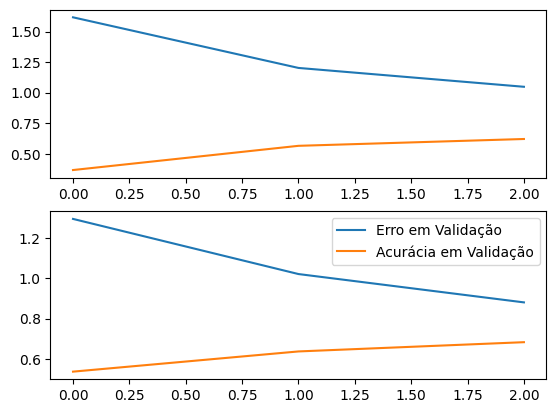

In [ ]:
# Plot
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'Erro em Treino')
fig1.plot(total_acc_train, label = 'Acurácia em Treino')
fig2.plot(total_loss_val, label = 'Erro em Validação')
fig2.plot(total_acc_val, label = 'Acurácia em Validação')
plt.legend()
plt.show()

### Avaliação do Modelo

In [ ]:
def avalia_modelo(loader_teste, model, device):
    model.eval()  # Set the model to evaluation mode
    total, correct = 0, 0

    with torch.no_grad():  # No need to track the gradients
        print('Começando:')
        for batch_index, (inputs, labels) in enumerate(loader_teste):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Obter previsões do modelo
            outputs = model(inputs).logits
            _, predicted = torch.max(outputs, 1)

            # Atualizar contadores
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if batch_index+1 % 100 == 0:
              print(f'Batch: {batch_index+1}/{len(loader_teste)} - Correct Predictions: {round(correct/total * 100,2)}')

    acuracia = 100 * correct / total
    print(f'Acurácia nos dados de teste: {acuracia:.2f}%')

    return acuracia

In [ ]:
# Avaliar o modelo
acuracia_teste = avalia_modelo(loader_teste, model, device)

Começando:
Acurácia nos dados de teste: 73.88%
